Assignment 4: 

Name: Anuj Zore

UID: 119198957

Course: CMSC733

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: 

In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
from skimage.util import img_as_float
from skimage import io, color
from skimage import draw
import matplotlib.pyplot as plt
import argparse, time
import math, copy
import numpy as np
import scipy.io
import cv2
from scipy.io import loadmat
from PIL import Image, ImageDraw
from google.colab.patches import cv2_imshow
from mpl_toolkits.axes_grid1 import ImageGrid
import os
from os import listdir
from google.colab.patches import cv2_imshow
import time
from os import listdir
from os.path import isfile, join
import numpy
import cv2

In [ ]:
def show_image(img, scale=1.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray() 
    plt.axis('off')
    plt.show()

# Part 1: SLIC Superpixels (50 Points)

## Overview

Superpixel algorithms group pixels into perceptually meaningful regions while respecting potential object contours, and thereby can replace the rigid pixel grid structure. Due to the reduced complexity, superpixels are becoming popular for various computer vision applications, e.g., multiclass object segmentation, depth estimation, human pose estimation, and object localization.

In this problem, you will implement a simple superpixel algorithm called Simple Linear Iterative Clustering (SLIC) that clusters pixels in the five-dimensional color and pixel coordinate space (e.g., r, g, b, x, y). The algorithm starts with a collection of K cluster centers initialized at an equally sampled regular grid on the image of N pixels. For each cluster, you define for a localized window 2S x 2S centered at the cluster center, where S = sqrt(N/K) is the roughly the space between the seed cluster centers. Then, you check whether the pixel within the 2S x 2S local window should be assigned to the cluster center or not (by comparing the distance in 5D space to the cluster center). Once you loop through all the clusters, you can update the cluster center by averaging over the cluster members. Iterate the pixel-to-cluster assignment process till convergence or maximum iterations reached.

Reference Paper: http://www.kev-smith.com/papers/SMITH_TPAMI12.pdf

You can refer to the following slide covered in Lecture_17_Segmentation.pptx here: https://drive.google.com/file/d/1bRmNBXgK1_kWcY-nhw_As5fP10aRhuDC/view?usp=share_link






## Data
**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1jbg2VMZ9yAJMHQNRCTgqZM1PyQRtcPyV
!unzip "/content/Part1_SLIC.zip" -d "/content/"

## Helper Functions:

### Code (15 pts)

In [ ]:
# Function which returns an object of class SuperPixel
class SuperPixel(object):

    def __init__(self, l=0, a=0, b=0, h=0, w=0):
        self.update(l, a, b, h, w)
        self.pixels = []

    def update(self, l, a, b, h, w):
        self.l = l
        self.a = a
        self.b = b
        self.h = h
        self.w = w
from skimage.segmentation import find_boundaries

def calcUSerror(segmap, gt):
  gt_segs = genSeg(gt, True)
  pred_segs = genSeg(segmap, False)
  in_, out_ = getInt(gt_segs, pred_segs)
  N = segmap.shape[0]*segmap.shape[1]
  mini = []
  for i in range(len(in_)):
    in_val = np.sum(in_[i])
    out_val = np.sum(out_[i])
    if in_val<out_val:
      temp_min = np.sum(in_[i])
    else:
      temp_min = np.sum(out_[i])      
    mini.append(temp_min.astype(np.byte))
  total_min = np.sum(np.asarray(mini))*gt.shape[1]
  US_error = (total_min/N)
  return round(US_error*100, 2)

def calcBoundaryRecall(segmap, gT):
  bound = find_boundaries(segmap)*255
  New = getGTMap(gT).astype(np.uint8)
  fn = bound - New
  fn[fn >= 0] = 0
  fn = np.abs(fn)
  tp = bound + New
   
  tp = tp/255
  fn = fn/255
  tp[tp<=1] = 0

  TP = np.sum(tp)/2
  FN = np.sum(fn)
  bp = (TP)/(TP+FN)  
  return round(bp*100, 2)

# Function which returns an object of class SuperPixel
def make_SuperPixel(h, w,img):
    return SuperPixel(img[h,w][0],img[h,w][1],img[h,w][2], h, w)

def plot_image(im,title,xticks=[],yticks= [],isCv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 : Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    if isCv2:
        im = im[:,:,::-1]
    plt.imshow(im)
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def display_clusters(img, seg, title = "Superpixels"):
    # image = np.copy(img)
    # for c in clusters:
    #     for p in c.pixels:
    #         image[p[0],p[1]][0] = c.l
    #         image[p[0],p[1]][1] = c.a
    #         image[p[0],p[1]][2] = c.b
    #     image[c.h, c.w][0] = 0
    #     image[c.h, c.w][1] = 0
    #     image[c.h, c.w][2] = 0
    # rgb_arr = color.lab2rgb(image) 
    # show_image(rgb_arr)

    clust = np.unique(seg)
    mapper_dict = {i: img[seg == i].mean(axis = 0)/255. for i in clust}

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]
    
    plot_image(seg_img,title)
    
    return  

def superpixel_plot(im,seg,title = "Superpixels"):
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]
    
    plot_image(seg_img,title)
    
    return seg_img

def gradient(im):
    """
    Function to calculate the gradient for LAB vector
    """

    grad = np.zeros((im.shape[0], im.shape[1]))

    for x in range(1, im.shape[0]-1):
      for y in range(1, im.shape[1]-1):
          X, Y = [], []
          for i in range(3):
              X.append(im[x+1, y, i] - im[x-1, y, i])
              Y.append(im[x, y+1, i] - im[x, y-1, i])
        
          grad[x,y] = np.linalg.norm(X) + np.linalg.norm(Y)
    
    return grad

def getListofFiles(dir):
    inputs = []

    for path in os.listdir(dir):
        if os.path.isfile(os.path.join(dir, path)):
            inputs.append(path)
    return inputs
def getImages(dir):
    images = []
    inp = getListofFiles(dir)
    for i in range(len(inp)):
        temp = cv2.imread(dir + inp[i])
        images.append(temp)
    return images, inp

def getGTMap(gT):
  new = gT[0][0][0][0][1]
  for i in range(1, gT.shape[1]):
    new = new + gT[0][i][0][0][1]
  new = new/gT.shape[1]
  new[new>0]=255
  new[new<=0]=0
  return new

def getGT(dir, inp):
  gt = []
  for i in range(len(inp)):
    temp_name = inp[i].split('.')
    act_name = temp_name[0] + '.mat'
    inp[i] = act_name
  for i in range(len(inp)):
    temp1 = loadmat(dir + inp[i])
    temp = temp1['groundTruth']
    gt.append(temp)
  return gt

def calcTime(t_start, t_stop):
  total_sec = t_stop - t_start
  hours = (int(total_sec/3600))
  minutes = (int(((total_sec/3600) - hours)*60))
  seconds = (((((total_sec/3600) - hours)*60) - minutes)*60)
  ret = ""
  if bool(hours):
    ret = ret + str("{:02d}".format(hours)) + "h "
  if bool(minutes):
    ret = ret + str("{:02d}".format(minutes)) + "m "
  if bool(seconds):
    ret = ret + str("{:0.2f}".format(seconds)) + "s"
  return ret


In [ ]:
def slic_algorithm_1(im, k, threshold,m):
    # f_distance = 0
    N = im.shape[0]*im.shape[1]
    S = (N/k)**0.5 
    lab = color.rgb2lab(im)

    # Cluster Centre initialization
    cluster_centres =  initialize_cluster_centers(lab, S)
    # Initial_Distance = []
    # for cluster in cluster_centre:
    #     l1, a1, b1 = lab[x,y]
    #     x1, y1 = x, y
    #     l2, a2, b2 = lab[cluster[0], cluster[1]]
    #     x2, y2 = cluster[0], cluster[1]
    #     dist1 = compute_res_error(m, S, l1, a1, b1, x1, y1, l2, a2, b2, x2, y2)
    #     Initial_Distance.append(dist1)
    # print(min(Initial_Distance))

    # Calculating gradient
    grad = gradient(lab)     
    flag = True
    segmap = np.zeros((im.shape[0], im.shape[1]))

    # # Initialize cluster centers on pixel grid in steps S
    # clusters = initialize_cluster_centers(S, image, img_h, img_w, clusters)
    min_cluster_centre = []
    # Move centers to position in 3x3 window with smallest gradient.
    new_cluster_centres = relocate_cluster_center_at_lowgrad(grad, cluster_centres)
    error = 12345
    for i in range(10000):                     # convergence loop
      if flag == True:
        # iterating over each pixel
        for x in range(im.shape[0]):        
           for y in range(im.shape[1]):

                # To find cluster centres within 2S distance 
                near_clusters = []
                for cluster in cluster_centres:
                    dist = ((x-cluster[0])**2 + (y-cluster[1])**(2))**0.5
                    if dist <= 2*S:
                        near_clusters.append(cluster)  

                # Finding cluster centre with error below threshold

                if near_clusters:
                    distance_array = []
                    for cluster in near_clusters:
                        l1, a1, b1 = lab[x,y]
                        x1, y1 = x, y
                        l2, a2, b2 = lab[cluster[0], cluster[1]]
                        x2, y2 = cluster[0], cluster[1]
                        dist = compute_res_error(m, S, l1, a1, b1, x1, y1, l2, a2, b2, x2, y2)
                        distance_array.append(dist)
                        # Getting the error at the Initialization
                        if x == 0: intial_distance = dist
                        # print(dist)
                        if dist<threshold :
                          flag = False
                          # Getting the error at the Convergence
                          if dist != 0: f_distance = dist
                          # f_distance = dist
                          break
                    
                    min_cluster_centre = near_clusters[np.argmin(distance_array)]

                    
                    # f_distance = min(distance_array)              
                for i in range(len(cluster_centres)):
                    if list(cluster_centres[i]) == list(min_cluster_centre):
                       segmap[x,y] = i
                # f_distance = min(distance_array)

        for index in range(len(cluster_centres)):
            chunk = np.where(segmap==index)
            if len(chunk[0])!=0:
              cluster_centres[index] = np.array([int(np.mean(chunk[0])),int(np.mean(chunk[1]))])
              
    return S, cluster_centres, lab, segmap, distance_array, intial_distance, f_distance



In [ ]:
# Functions for Simple Linear Iterative Clustering (SLIC)

def initialize_cluster_centers(im,S):
    #### Write your code here ####
    # To Do: Initialize "clusters" by sampling pixels at an equally sampled regular grid (distanced by S)
    # on the image of N pixels. N = img_h X img_w. Hint: clusters.append(make_superPixel(h, w, image)) to create each cluster/super-pixel.
    cluster_centres = [] 
    for x in range(int(S),im.shape[0],int(S)):
        for y in range(int(S),im.shape[1],int(S)):
            cluster_centres.append([x,y]) 
    return cluster_centres



def relocate_cluster_center_at_lowgrad(grad, cluster_centres):
    #### Write your code here ####
    # To Do:
    # for each cluster c, reassign cluster to the pixel having smallest gradient value.
    # Step 1: compute gradient wrt cluster-center c.h, c.w in 3X3 neighborhood of cluster center.
    # Step 2: Similarly, compute gradient for each pixel in 3X3 spatial neighborhood of cluster c.
    # Step 3. Reassign cluster-center to the pixel (x,y) having the lowest gradient. 
    # Hint: c.update(img[x,y][0], img[h,w][1], img[x,y][2], x, y)

    for i in range(len(cluster_centres)):
       
        # indexing nearby 3*3 region
        sub_array = grad[cluster_centres[i][0]-3 : cluster_centres[i][0]+3, cluster_centres[i][1]-3 : cluster_centres[i][1]+3]
        
        # Finding min gradient
        index = np.where(sub_array==sub_array.min())

        # Assigning the cluster centre to min gradient index
        change = list(zip(index[0],index[1]))[0]
        cluster_centres[i] = [cluster_centres[i][0]-3 + change[0], cluster_centres[i][1]-3 + change[1]]

    return cluster_centres

# def assign_cluster(clusters, S, image, img_h, img_w, cluster_tag, dis):
#     #### Write your code here ####
#     # To Do: Compare each pixel to cluster center within 2S pixel distance and assign to nearest cluster using the "distance metric"
#     # (involving both color and spatial dimensions of pixel and cluster, 
#     # Hints: 
#     # 1. use "dis" matrix for comparing distances.
#     # 2. You can use c.pixels.append((h, w)) to keep track of cluster-assignments.
#     return None

# # def update_clusters(clusters):
# #     #### Write your code here ####
# #     # To Do: For each cluster, update the cluster center with mean of the pixels assigned (c.pixels)
# #     return None

def compute_res_error(m, S, l1, a1, b1, x1, y1, l2, a2, b2, x2, y2):
    #### Write your code here ####
    # error = Compute L1 distance between previous cluster-centres and new cluster centers.

    """
    This function is used to calculate the weighted euclidean distance from lab and xy coordinates 
    """
    # Colour distance
    lab_distance = ((l1-l2)**2 + (a1-a2)**2 + (b1-b2)**2)**0.5
    # Spatial distance
    cood_distance = ((x1-x2)**2 + (y1-y2)**2)**0.5

    error = lab_distance + (m/S)*cood_distance
    return error

def slic_algorithm(im, k, threshold,m):
    
    N = im.shape[0]*im.shape[1]
    S = (N/k)**0.5 
    lab = color.rgb2lab(im)

    # Cluster Centre initialization
    cluster_centres =  initialize_cluster_centers(lab, S)

    # Calculating gradient
    grad = gradient(lab)     
    flag = True
    segmap = np.zeros((im.shape[0], im.shape[1]))

    # # Initialize cluster centers on pixel grid in steps S
    # clusters = initialize_cluster_centers(S, image, img_h, img_w, clusters)
    min_cluster_centre = []
    # Move centers to position in 3x3 window with smallest gradient.
    new_cluster_centres = relocate_cluster_center_at_lowgrad(grad, cluster_centres)
    error = 12345
    for i in range(10000):                     # convergence loop
      if flag == True:
        # iterating over each pixel
        for x in range(im.shape[0]):        
           for y in range(im.shape[1]):

                # To find cluster centres within 2S distance 
                near_clusters = []
                for cluster in cluster_centres:
                    dist = ((x-cluster[0])**2 + (y-cluster[1])**(2))**0.5
                    if dist <= 2*S:
                        near_clusters.append(cluster)  

                # Finding cluster centre with error below threshold

                if near_clusters:
                    distance_array = []
                    for cluster in near_clusters:
                        l1, a1, b1 = lab[x,y]
                        x1, y1 = x, y
                        l2, a2, b2 = lab[cluster[0], cluster[1]]
                        x2, y2 = cluster[0], cluster[1]
                        dist = compute_res_error(m, S, l1, a1, b1, x1, y1, l2, a2, b2, x2, y2)
                        distance_array.append(dist)
                        # print(dist)
                        if dist<threshold:
                          flag = False
                          # print("flag inactive")
                          # print(dist)
                          break
                    
                    min_cluster_centre = near_clusters[np.argmin(distance_array)]
                    # d = d.append(distance_array)                    
                for i in range(len(cluster_centres)):
                    if list(cluster_centres[i]) == list(min_cluster_centre):
                       segmap[x,y] = i

        for index in range(len(cluster_centres)):
            chunk = np.where(segmap==index)
            if len(chunk[0])!=0:
              cluster_centres[index] = np.array([int(np.mean(chunk[0])),int(np.mean(chunk[1]))])
              
    return S, cluster_centres, lab, segmap, distance_array


### Write-up (35 pts)
* a) [5 points] Explain your distance function for measuring the similarity between a pixel and cluster in the 5D space.
* b) [5 points] Choose one image, try three different weights on the color and spatial feature and show the three segmentation results. Describe what you observe.
* c) [5 points] Choose one image, show the error (1) at the initialization and (2) at convergence. Note: error - distance to cluster center in the 5D space.
* d) [10 points] Choose one image and show three superpixel results with different number of K, e.g., 64, 256, 1024 and run time for each K.
* e)  [10 points] Run your algorithms on the subset (50 images) of Berkeley Segmentation Dataset (BSD) with K = 64, 256 and 1024 and report averaged run-time per image for the BSD.


**a]  Explain your distance function for measuring the similarity between a pixel and cluster in the 5D space.**
Answer: 

1] SLIC algorithm takes as input a desired number of approximately equally-sized superpixels which is K. <br>
2] At the onset of the algorithm, K superpixel cluster centers Cₖ= [lₖ, aₖ, bₖ, xₖ, yₖ] are chosen with k= [1,K] at regular grid intervals S. <br> 3] Since the spatial extent of any superpixel is approximately S²(the approximate area of a super-pixel), it is safely assumed that pixels that are associated with this cluster center lie within a 2S×2S area around the superpixel center on the xy plane. <br>
4] The normalized distance measure (Dₛ) to be used in the 5D space is defined as :

Dₛ = dₗₐᵦ +( m/S)*dₓᵧ …. (eq 1)

where <br>
dₗₐᵦ = √((lₖ−lᵢ)²+ (aₖ−aᵢ)²+ (bₖ−bᵢ)²), <br>
dₓᵧ = √((xₖ−xᵢ)²+ (yₖ−yᵢ)²) <br>
and Dₛ is the sum of the lab distance (dₗₐᵦ) <br>
5] This algorithm begins by sampling K regularly spaced cluster centers and moving them to seed locations corresponding to the lowest gradient position in a 3×3 neighborhood (This is done to avoid placing them at an edge and to reduce the chances of choosing a noisy pixel).<br> 6] Image gradients are computed as:

G(x,y) = ‖I(x+ 1,y)−I(x−1,y)‖²+‖I(x,y+ 1)−I(x,y−1)‖² <br>

where I(x,y) is the lab vector corresponding to the pixel at position (x,y), <br> and ‖.‖ is the L2 norm.<br> 6] Each pixel in the image is associated with the nearest cluster center whose search area overlaps this pixel.<br> 7] New center is computed as the average labxy vector of all the pixels belonging to the cluster.


---



**b] Choose one image, try three different weights on the color and spatial feature and show the three segmentation results. Describe what you observe.**





Output Images with Weights: m = 10, m = 20 and m = 50 respectively


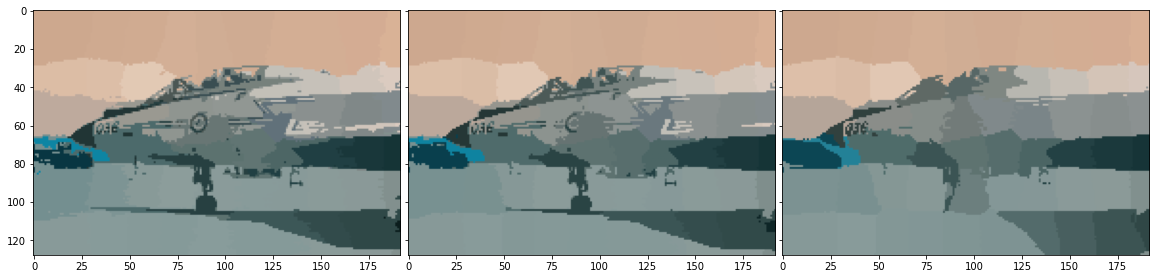

In [ ]:
# Here, We have implemented three different weights (m = 10,20,50) on the color and spatial features.
import warnings
warnings.filterwarnings('ignore')
org_img = cv2.imread( "/content/Part1_SLIC/BSD_data/images/10081.jpg")
width = int(org_img.shape[1] * 0.4)
height = int(org_img.shape[0] * 0.4)  
org_img = cv2.resize(org_img, (width, height), interpolation = cv2.INTER_AREA)
image_params = []
k = 64
threshold = 0.5

# Case1 : Weight(m) = 10
m = 10
S, cluster_centres, lab, segmap,d = slic_algorithm(org_img, k, threshold,m)
image_params.append([org_img, S, cluster_centres, lab, segmap])
img1 = superpixel_plot(org_img ,segmap, title ="Superpixel plot: Weight: "+ str(m))

# Case2 : Weight(m) = 20
m = 20
S, cluster_centres, lab, segmap,d = slic_algorithm(org_img, k, threshold,m)
image_params.append([org_img, S, cluster_centres, lab, segmap])
img2 = superpixel_plot(org_img ,segmap, title = "Superpixel plot: Weight: "+ str(m))

# Case3 : Weight(m) = 50
m = 50
S, cluster_centres, lab, segmap,d = slic_algorithm(org_img, k, threshold,m)
image_params.append([org_img, S, cluster_centres, lab, segmap])
img3 = superpixel_plot(org_img ,segmap, title = "Superpixel plot: Weight: "+ str(m))
from mpl_toolkits.axes_grid1 import ImageGrid

# Displaying Three Output in ImageGrid
fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(1, 3),  
                 axes_pad=0.1,  
                 )

for ax, im in zip(grid, [img1, img2, img3]):
    ax.imshow(im)
print("Output Images with Weights: m = 10, m = 20 and m = 50 respectively")
plt.show()


**Observation:** From the three different weights taken as the input, we can observe that as the weight increases the resulting image becomes more distorted and a patchy texture can be seen in the images.

**c)  Choose one image, show the error (1) at the initialization and (2) at convergence. Note: error - distance to cluster center in the 5D space.**



In [ ]:
org_img = cv2.imread( "/content/Part1_SLIC/BSD_data/images/10081.jpg")

# Initializing the Number of Clusters, Threshold and Weights
k = 64
threshold = 1
m = 10

width = int(org_img.shape[1] * 0.4)
height = int(org_img.shape[0] * 0.4)  
org_img = cv2.resize(org_img, (width, height), interpolation = cv2.INTER_AREA)
image_params = []

# Running the SLIC Algorithm
S, cluster_centres, lab, segmap,d, i_distance, f_distance = slic_algorithm_1(org_img, k, threshold,m)
print("Error at the Intitialization :  "+ str(i_distance))
print("Error at the Convergence :  "+ str(f_distance))

Error at the Intitialization :  38.856943388475145
Error at the Convergence :  0.8894016988188418


d) Choose one image and show three superpixel results with different number of K, e.g., 64, 256, 1024 and run time for each K.

Time required for K = 64 :  10.890600000000177
Time required for K = 256 :  44.498459999999795
Time required for K = 1024 :  178.09624600000006
Output Images with Weights: k = 64, k = 256 and k = 1024 respectively


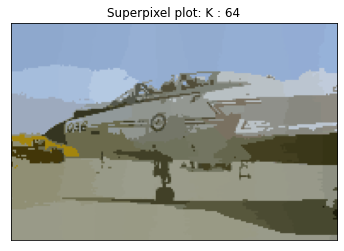

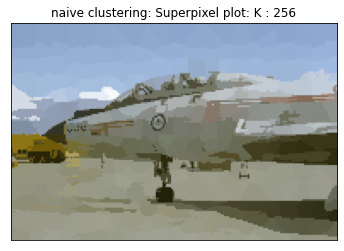

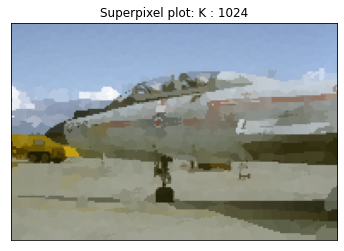

In [ ]:
# Here, We have implemented three different number of clusters k = 64, 256, 1024
import warnings
warnings.filterwarnings('ignore')
org_img = cv2.imread( "/content/Part1_SLIC/BSD_data/images/10081.jpg")
width = int(org_img.shape[1] * 0.4)
height = int(org_img.shape[0] * 0.4)  
org_img = cv2.resize(org_img, (width, height), interpolation = cv2.INTER_AREA)
image_params = []
m = 10
threshold = 0.5

# Case1 : K = 64
k = 64
t0= time.clock()
S, cluster_centres, lab, segmap,d = slic_algorithm(org_img, k, threshold,m)
t1 = time.clock() - t0
print("Time required for K = 64 :  "+ str(t1))
image_params.append([org_img, S, cluster_centres, lab, segmap])
# print("Output Image ------->")
img11 = superpixel_plot(org_img ,segmap, title ="Superpixel plot: K : "+ str(k))
# plt.show(img11)

# Case2 : k = 256
k = 256
t2= time.clock()
S, cluster_centres, lab, segmap,d = slic_algorithm(org_img, k, threshold,m)
t3 = time.clock() - t2
print("Time required for K = 256 :  "+ str(t3))
image_params.append([org_img, S, cluster_centres, lab, segmap])
# print("Output Image ------->")
img22 = superpixel_plot(org_img ,segmap, title =  "naive clustering: Superpixel plot: K : "+ str(k))
# plt.show(img22)


# Case3 : k = 1024
k = 1024
t4= time.clock()
S, cluster_centres, lab, segmap,d = slic_algorithm(org_img, k, threshold,m)
t5 = time.clock() - t4
print("Time required for K = 1024 :  "+ str(t5))
image_params.append([org_img, S, cluster_centres, lab, segmap])
# print("Output Image ------->")
img33 = superpixel_plot(org_img ,segmap, title = "Superpixel plot: K : "+ str(k))

for ax, im in zip(grid, [img11, img22, img33]):
    ax.imshow(im)
print("Output Images with Weights: k = 64, k = 256 and k = 1024 respectively")
plt.show()


**e) Run your algorithms on the subset (50 images) of Berkeley Segmentation Dataset (BSD) with K = 64, 256 and 1024 and report averaged run-time per image for the BSD.**

In [ ]:
# Time for Complete BSD Dataset at K = 64
thres = 1
mypath='/content/Part1_SLIC/BSD_data/images'
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
images = numpy.empty(len(onlyfiles), dtype=object)
t1 = time.clock()
for n in range(0, len(onlyfiles)):
  images[n] = cv2.imread( join(mypath,onlyfiles[n]) )
  k = 64
  S, cluster_centres, lab, segmap,d = slic_algorithm(org_img, k, threshold,m)
t2 = time.clock() - t1
print("Average time for k = 64 is :" + str(t2/len(onlyfiles)))

  

In [ ]:
print("Average time for k = 64 is :" + str(t2/len(onlyfiles)))

Average time for k = 64 is :10.218189300000004


In [ ]:
# Time for Complete BSD Dataset at K = 256
thres = 1
mypath='/content/Part1_SLIC/BSD_data/images'
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
images = numpy.empty(len(onlyfiles), dtype=object)
t1 = time.clock()
for n in range(0, len(onlyfiles)):
  images[n] = cv2.imread( join(mypath,onlyfiles[n]) ) 
  k = 256
  S, cluster_centres, lab, segmap,d = slic_algorithm(org_img, k, threshold,m)
t2 = time.clock() - t1
print("Average time for k = 256 is :" + str(t2/len(onlyfiles)))

  

Average time for k = 256 is :36.268759519999996


In [ ]:
# Time for 10 images at K = 1024
thres = 1
mypath='/content/Part1_SLIC/BSD_data/images'
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
images = numpy.empty(len(onlyfiles), dtype=object)
t1 = time.clock()
for n in range(0, 10):
  images[n] = cv2.imread( join(mypath,onlyfiles[n]) )
  k = 1024
  S, cluster_centres, lab, segmap,d = slic_algorithm(org_img, k, threshold,m)
t2 = time.clock() - t1


  

In [ ]:
print("Average time for k = 1024 is :" + str(t2/10))

Average time for k = 1024 is :161.80169429999995


### Extra Credit (20 pts)
* f) [upto 10 points] Implement and report two types of metrics (1) boundary recall and (2) under-segmentation error with K = 64, 256 and 1024 on the BSD (last part of write-up).
* g) [upto 10 points] Try to improve your result from first part of extra-credit. You may try different color space (e.g., CIELab, HSV) (See Sec 4.5 in the paper), richer image features (e.g., gradients) or any other ideas you come up with. Report the accuracy on boundary recall and under-segmentation error with K = 256. Compare the results with first-part of extra-credit and explain why you get better results.

In [ ]:
def initialize_cluster_centers(im,S):
    cluster_centres = [] 
    for x in range(int(S),im.shape[0],int(S)):
        for y in range(int(S),im.shape[1],int(S)):
            cluster_centres.append([x,y]) 
    return cluster_centres



def relocate_cluster_center_at_lowgrad(grad, cluster_centres):
    for i in range(len(cluster_centres)):
        sub_array = grad[cluster_centres[i][0]-3 : cluster_centres[i][0]+3, cluster_centres[i][1]-3 : cluster_centres[i][1]+3]
        index = np.where(sub_array==sub_array.min())
        change = list(zip(index[0],index[1]))[0]
        cluster_centres[i] = [cluster_centres[i][0]-3 + change[0], cluster_centres[i][1]-3 + change[1]]

    return cluster_centres


def compute_res_error(m, S, l1, a1, b1, x1, y1, l2, a2, b2, x2, y2):
    lab_distance = ((l1-l2)**2 + (a1-a2)**2 + (b1-b2)**2)**0.5
    cood_distance = ((x1-x2)**2 + (y1-y2)**2)**0.5

    error = lab_distance + (m/S)*cood_distance
    return error


def slic_algorithm(im, k, threshold, method):
    conv = {"regular":color.rgb2lab, "HSV": color.rgb2hsv, "CIE": color.rgb2rgbcie}
    N = im.shape[0]*im.shape[1]
    S = (N/k)**0.5 
    lab = conv[method](im)
    cluster_centres =  initialize_cluster_centers(lab, S)
    grad = gradient(lab)     
    m = 10
    flag = True
    segmap = np.zeros((im.shape[0], im.shape[1]))
    min_cluster_centre = []
    new_cluster_centres = relocate_cluster_center_at_lowgrad(grad, cluster_centres)
    error = 12345
    for i in range(10000):
      if flag == True:
        for x in range(im.shape[0]):        
           for y in range(im.shape[1]):
                near_clusters = []
                for cluster in cluster_centres:
                    dist = ((x-cluster[0])**2 + (y-cluster[1])**2)**0.5
                    if dist <= 2*S:
                        near_clusters.append(cluster)

                if near_clusters:
                    distance_array = []
                    for cluster in near_clusters:
                        l1, a1, b1 = lab[x,y]
                        x1, y1 = x, y
                        l2, a2, b2 = lab[cluster[0], cluster[1]]
                        x2, y2 = cluster[0], cluster[1]
                        dist = compute_res_error(m, S, l1, a1, b1, x1, y1, l2, a2, b2, x2, y2)
                        distance_array.append(dist)
                        if dist<threshold:
                          flag = False
                          break
                    
                    min_cluster_centre = near_clusters[np.argmin(distance_array)]
                                        
                for i in range(len(cluster_centres)):
                    if list(cluster_centres[i]) == list(min_cluster_centre):
                       segmap[x,y] = i

        for index in range(len(cluster_centres)):
            chunk = np.where(segmap==index)
            if len(chunk[0])!=0:
              cluster_centres[index] = np.array([int(np.mean(chunk[0])),int(np.mean(chunk[1]))])
              
    return S, cluster_centres, lab, segmap  

def getListofFiles(dir):
    inputs = []

    for path in os.listdir(dir):
        if os.path.isfile(os.path.join(dir, path)):
            inputs.append(path)
    return inputs

def getImages(dir):
    images = []
    inp = getListofFiles(dir)
    for i in range(len(inp)):
        temp = cv2.imread(dir + inp[i])
        images.append(temp)
    return images, inp

def resizeImage(img, factor):
  return cv2.resize(img, (int(img.shape[1]*factor), int(img.shape[0]*factor)), interpolation = cv2.INTER_AREA)

def calcTime(t_start, t_stop):
  total_sec = t_stop - t_start
  hours = (int(total_sec/3600))
  minutes = (int(((total_sec/3600) - hours)*60))
  seconds = (((((total_sec/3600) - hours)*60) - minutes)*60)
  ret = ""
  if bool(hours):
    ret = ret + str("{:02d}".format(hours)) + "h "
  if bool(minutes):
    ret = ret + str("{:02d}".format(minutes)) + "m "
  if bool(seconds):
    ret = ret + str("{:0.2f}".format(seconds)) + "s"
  return ret
def getGT(dir, inp):
  gt = []
  for i in range(len(inp)):
    temp_name = inp[i].split('.')
    act_name = temp_name[0] + '.mat'
    inp[i] = act_name
  for i in range(len(inp)):
    temp1 = loadmat(dir + inp[i])
    temp = temp1['groundTruth']
    gt.append(temp)
  return gt
def getGTMap(gT):
  new = gT[0][0][0][0][1]
  for i in range(1, gT.shape[1]):
    new = new + gT[0][i][0][0][1]
  new = new/gT.shape[1]
  new[new>0]=255
  new[new<=0]=0
  return new

def calcBoundaryRecall(segmap, gT):
  bound = find_boundaries(segmap)*255
  New = getGTMap(gT).astype(np.uint8)
  fn = bound - New
  fn[fn >= 0] = 0
  fn = np.abs(fn)
  tp = bound + New
   
  tp = tp/255
  fn = fn/255
  tp[tp<=1] = 0

  TP = np.sum(tp)/2
  FN = np.sum(fn)
  bp = (TP)/(TP+FN)  
  return round(bp*100, 2)

def getbiggerSeg(gt):
  number_of_segs = []
  for i in range(len(gt)):
    num = len(np.unique(gt[0][i][0][0][0]))
    number_of_segs.append(num)
  ind = number_of_segs.index(max(number_of_segs))
  biggerSeg = gt[0][ind][0][0][0]
  return biggerSeg

def genSeg(Seg, isGT):
  all_segs = []
  if isGT:
    seg = getbiggerSeg(Seg)
    # for i in range(Seg.shape[1]):
    #   seg = Seg[0][i][0][0][0]
    for j in range(len(np.unique(seg))):
      temp = np.zeros(seg.shape).astype(np.byte)
      temp[np.where(seg == np.unique(seg)[j])] = 1
      all_segs.append(temp)
  else:
    for j in range(len(np.unique(Seg))):
      temp = np.zeros(Seg.shape).astype(np.byte)
      temp[np.where(Seg == np.unique(Seg)[j])] = 1
      all_segs.append(temp)
      # break
  return all_segs

def checkInter(seg1, seg2, in_, out_):
  seg_in = seg1 + seg2
  seg_in[seg_in<2]=0
  seg_in = seg_in/2
  seg_out = np.abs(seg2 - seg_in)
  if np.sum(seg_in) != 0:
    in_.append(seg_in)
    out_.append(seg_out)
  return in_, out_

def getInt(gt_segs, pred_segs):
  seg_in1 = []
  seg_out1 = []
  for i in range(len(gt_segs)):
    for j in range(len(pred_segs)):
      seg_in1, seg_out1 = checkInter(gt_segs[i], pred_segs[j], seg_in1, seg_out1)
  return seg_in1, seg_out1

def calcUSerror(segmap, gt):
  gt_segs = genSeg(gt, True)
  pred_segs = genSeg(segmap, False)
  in_, out_ = getInt(gt_segs, pred_segs)
  N = segmap.shape[0]*segmap.shape[1]
  mini = []
  for i in range(len(in_)):
    in_val = np.sum(in_[i])
    out_val = np.sum(out_[i])
    if in_val<out_val:
      temp_min = np.sum(in_[i])
    else:
      temp_min = np.sum(out_[i])      
    mini.append(temp_min.astype(np.byte))
  total_min = np.sum(np.asarray(mini))*gt.shape[1]
  US_error = (total_min/N)
  return round(US_error*100, 2)

Time taken for 64 clusters: 58.57s
Time taken for 256 clusters: 03m 15.59s
Time taken for 1024 clusters: 11m 53.27s
Total time take for entire dataset: 16m 9.88s


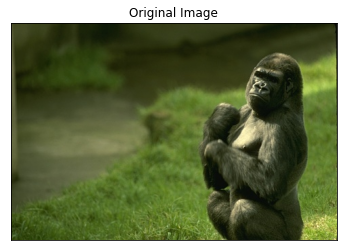

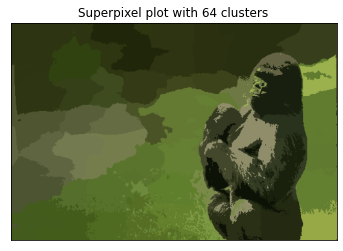

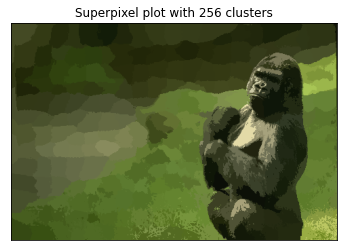

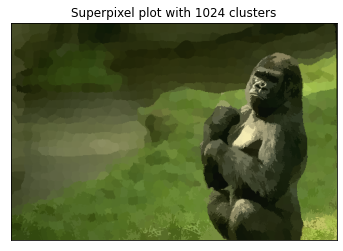

In [ ]:
start = time.perf_counter()
home = "/content/Part1_SLIC/BSD_data/images/"
gt_dir = "/content/Part1_SLIC/BSD_data/groundTruth/test/"
images, files = getImages(home)
gt = getGT(gt_dir, files)

maps = []
methods = ["regular", "HSV", "CIE"]
image_params = []
num_of_images = 1
# for i in range(len(images)):
for i in range(num_of_images):
  cluster_maps = []
  org_img = images[i]
  k = [64, 256, 1024]
  # k = [1024]
  thres = 0.5
  plot_image(org_img, "Original Image")
  for j in range(len(k)):  
    time_start = time.perf_counter()
    S, cluster_centres, lab, segmap = slic_algorithm(org_img, k[j], thres, methods[0])
    time_stop = time.perf_counter()
    cluster_maps.append(segmap)
    print(f"Time taken for {k[j]} clusters: {calcTime(time_start, time_stop)}")
    image_params.append([org_img, S, cluster_centres, lab, segmap])
    superpixel_plot(org_img ,segmap, title=f"Superpixel plot with {k[j]} clusters")
    # break
  maps.append(cluster_maps)
  # break
stop = time.perf_counter()
print(f"Total time take for entire dataset: {calcTime(start, stop)}")

In [ ]:
# print(len(images))
from skimage.segmentation import find_boundaries
for i in range(len(maps)):
  gT = gt[i]
  segMap = maps[i]
  
  for j in range(len(segMap)):
    bR = calcBoundaryRecall(segMap[j], gT)
    print(f"Boundary Recall Error for image {i+1}: {bR}%")
    us = calcUSerror(segMap[j], gT)
    print(f"Under-Segmentation Error for image {i+1}: {us}%")

Boundary Recall Error for image 1: 28.28%
Under-Segmentation Error for image 1: 2.95%
Boundary Recall Error for image 1: 32.16%
Under-Segmentation Error for image 1: 12.58%
Boundary Recall Error for image 1: 37.7%
Under-Segmentation Error for image 1: 27.74%


### Hints 
- For main part, you CAN NOT use any library such as skimage / cv2 to perform or implement SLIC segmentation.
- For better visualization, you may use external function (skimage.segmentation.mark_boundaries) for your purpose.
- For EXTRA CREDIT part, you are allowed to use external library for metrics (boundary recall and under-segmentation error)

# Part 2: Graph-cut Segmentation (50 points)

## Overview

Let us apply Graph-cuts for foreground/background segmentation. In the “cat” image, you are given a rough polygon of a foreground cat. Apply graph-cut based method to see if we can get a better segmentation!

Firstly, use the provided polygon to obtain an estimate of foreground and background color likelihood. You may choose the likelihood distribution (e.g., color histograms or color mixture of Gaussians.).

Secondly, apply graph-cut code (cv2.grabcut) to do better segmentation. You can use the provided bounding-boxes and use "cv2 package" for the implementation sake. You are required to draw interesting conclusions on how it performs on different samples.

## Data 

In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
from skimage.util import img_as_float
from skimage import io, color
from skimage import draw
import matplotlib.pyplot as plt
import argparse, time
import math, copy
import numpy as np
import scipy.io
import cv2
from google.colab.patches import cv2_imshow ## Use this to show image in colab
from PIL import Image, ImageDraw
from sklearn import mixture
from scipy import ndimage
import time 

In [ ]:
# Download Data -- run this cell only one time per runtime
# !gdown 1ObpNoshjKMcB7SFvrTuoKe61IE-HG95n
!gdown 1Tw_gk0yylwl2X1leubz0mlERpxsqLiub
!unzip "/content/Part2_GraphCut.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1Tw_gk0yylwl2X1leubz0mlERpxsqLiub
To: /content/Part2_GraphCut.zip
100% 264k/264k [00:00<00:00, 84.7MB/s]
Archive:  /content/Part2_GraphCut.zip
   creating: /content/Part2_GraphCut/
  inflating: /content/Part2_GraphCut/dog.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._dog.jpg  
  inflating: /content/Part2_GraphCut/messi.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._messi.jpg  
  inflating: /content/Part2_GraphCut/.DS_Store  
  inflating: /content/__MACOSX/Part2_GraphCut/._.DS_Store  
  inflating: /content/Part2_GraphCut/plane.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._plane.jpg  
  inflating: /content/Part2_GraphCut/bird.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._bird.jpg  
  inflating: /content/Part2_GraphCut/cat.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._cat.jpg  
  inflating: /content/Part2_GraphCut/cat_poly.mat  
  inflating: /content/__MACOSX/Part2_GraphCut/._cat_poly.mat  


## Helper Functions

#### Code (15 pts)

In [ ]:

def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

def show_image(img, scale=1.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray() 
    plt.axis('off')
    plt.show()

# Get a normalized version of the given histograms (divide by sum)
def normalize_histograms(histograms):
  return np.float32([h / h.sum() for h in histograms])

def mask_for_fg(img, img_mask):
  # Write code here 
  # to generate foreground region (and everything else masked out).
  mask_rgb = np.zeros_like(img)
  mask_rgb[:, :, 0] = img_mask
  mask_rgb[:, :, 1] = img_mask
  mask_rgb[:, :, 2] = img_mask
  fg_image = img*mask_rgb
  return fg_image

def mask_for_bg(img, img_mask):
  # Write code here
  # generate background region (and everything else masked out).
  bg_mask = np.zeros_like(img)
  bg_mask[:, :, 0] = np.invert(img_mask)
  bg_mask[:, :, 1] = np.invert(img_mask)
  bg_mask[:, :, 2] = np.invert(img_mask)
  bg_image= img*bg_mask
  return bg_image

def visualize_likelihood_map1(gmm_bg, gmm_fg, img):
  # Write your code here.

  likelihood_map_bg = gmm_bg.score_samples(img.reshape(-1, 3))
  likelihood_map_fg = gmm_fg.score_samples(img.reshape(-1, 3))

  plt.figure(figsize=(10, 10))

  plt.subplot(1, 2, 1)
  plt.imshow(likelihood_map_bg.reshape(img.shape[:2]), cmap='jet')
  plt.colorbar()
  plt.title("Background (Sink) Likelihood Map")

  plt.subplot(1, 2, 2)
  plt.imshow(likelihood_map_fg.reshape(img.shape[:2]), cmap='jet')
  plt.colorbar()
  plt.title("Foreground (Source) Likelihood Map")
  plt.show()

  return None

def visualize_likelihood_map(gmm_bg, gmm_fg, img):

  # Write your code here.
  h, w = img.shape[:2]
  img_channel = img.reshape(h*w, -1)

  BG_channel = gmm_bg.score_samples(img_channel)
  BG_img = BG_channel.reshape(h,w)
  show_image(BG_img)

  FG_channel = gmm_fg.score_samples(img_channel)
  FG_img = FG_channel.reshape(h,w)
  show_image(FG_img)

  return None


def gaussian_model(img):
  h, w = img.shape[:2]
  img_channel = img.reshape(h*w, -1)

  # Write your code here.
  # fit gaussian model on a given image.
  gaussian_model = mixture.GaussianMixture(n_components=8, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=25, n_init=3)
  gaussian_model.fit(img_channel)
  gmm_model, gmm_labels = gaussian_model, gaussian_model.score_samples(img_channel).reshape(h,w)

  return gmm_model, gmm_labels




def run_grabcut(img, bbox,iteration):
  # Write your code here.
  # You can use opencv cv2.grabCut algorithm with "cv2.GC_INIT_WITH_RECT" to implement this.

  grabcut_mask = np.zeros(img.shape[:2],np.uint8)
  bgModel, fgModel = np.zeros((1,65),np.float64), np.zeros((1,65),np.float64)

  cv2.grabCut(img,grabcut_mask,bbox,bgModel,fgModel,iteration,cv2.GC_INIT_WITH_RECT)
  grabcut_mask2 = np.where((grabcut_mask==2)|(grabcut_mask==0),0,1).astype('uint8')

  return (grabcut_mask2, bgModel, fgModel)



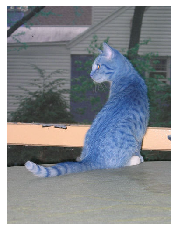

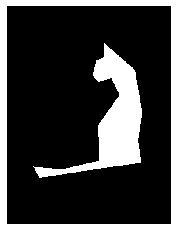

In [ ]:
### Main Block: ###

# read image
img_name = 'cat'
img_path = '/content/Part2_GraphCut/cat.jpg'
img = cv2.imread(img_path)

# read image_mask
poly = scipy.io.loadmat('/content/Part2_GraphCut/cat_poly.mat')['poly']
img_mask = poly2mask(poly[:,1], poly[:,0], (img.shape[0],img.shape[1]))

show_image(img)
show_image(img_mask)

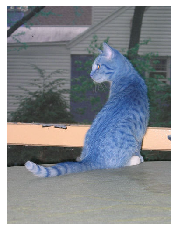

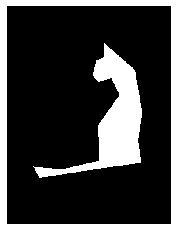

In [ ]:
### Main Block: ###

# read image
img_name = 'cat'
img_path = '/content/Part2_GraphCut/cat.jpg'
img = cv2.imread(img_path)

# read image_mask
poly = scipy.io.loadmat('/content/Part2_GraphCut/cat_poly.mat')['poly']
img_mask = poly2mask(poly[:,1], poly[:,0], (img.shape[0],img.shape[1]))

show_image(img)
show_image(img_mask)

In [ ]:
# 1. Fit Gaussian mixture model for foreground regions.

# Generate image (fg_image) with background masked using img_mask
fg_image = mask_for_fg(img, img_mask)
gmm_fg, fg_gmm_labels = gaussian_model(fg_image)


# 2. Fit Gaussian mixture model for background regions.
# Generate image (fg_image) with foreground masked using img_mask
bg_image = mask_for_bg(img, img_mask)
gmm_bg, bg_gmm_labels = gaussian_model(bg_image)

### Write-up (35 points)

- a) [5 points] Explain your foreground and background likelihood function.
- b) [10 points] Your foreground and background likelihood map. 

Display P(foreground|pixel) as an intensity map (bright = confident foreground).
- c) [15 points] Implement grabcut segmentation using cv2 package and draw insights on how the segmentation performs on different sample images (hard v/s easy).
- d) [5 points] Try grabcut algorithm with different "iterCount" to see if results improve in certain cases.

**a) Explain your foreground and background likelihood function.**

1] A Gaussian Mixture Model (GMM) is used to model the foreground and background. We have used the GaussianMixture method from the sklearn.mixture library.<br> 2] Gaussian mixture model and expectation maximimization has been utilized in ge code. The model will have 8 cluster center and will assign the pixel to each cluster. <br>
3] GMM learns and creates new pixel distribution. We train the background and the foreground image individually and apply to the input image to get the estimation.<br>4] That is, the unknown pixels are labeled either probable foreground or probable background depending on their relationship with the other hard-labeled pixels in terms of color statistics (just like clustering).<br>
5] Next, we computed Log-Likelihood using the score_samples

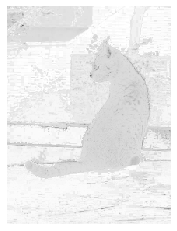

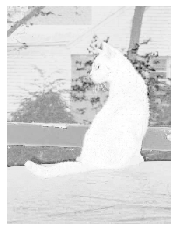

In [ ]:
visualize_likelihood_map(gmm_bg, gmm_fg, img)

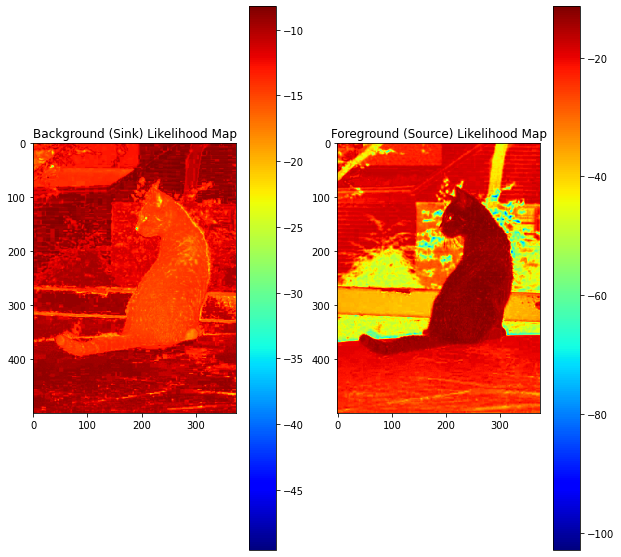

In [ ]:
visualize_likelihood_map1(gmm_bg, gmm_fg, img)

**c) *Implement* grabcut segmentation using cv2 package and draw insights on how the segmentation performs on different sample images (hard v/s easy).**

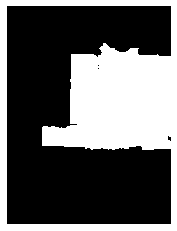

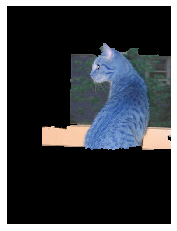

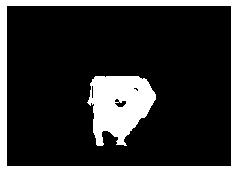

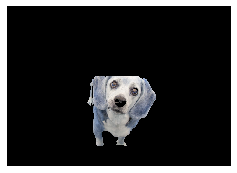

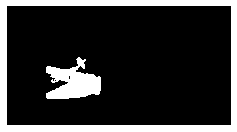

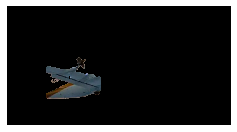

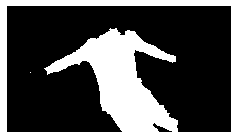

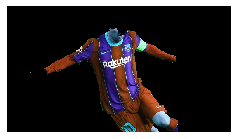

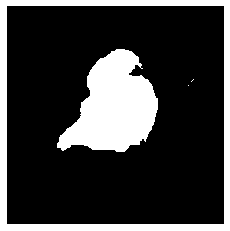

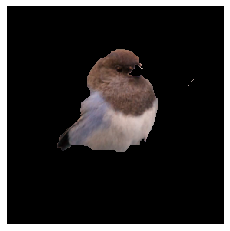

In [ ]:
# 4. Run grabcut algorithm.
bboxes = {'cat':(80,80,320,250), 'dog':(50,300,600,300), 'plane': (180,80,250,800), 'messi':(10,80,600,500), 'bird':(100,100,350,250)}
bbox = bboxes[img_name]

for key,val in bboxes.items():
  bbox = bboxes[key]
  address='/content/Part2_GraphCut/'+key+'.jpg'
  img = cv2.imread(address)

  (grabcut_mask, bgModel, fgModel) = run_grabcut(img, bbox,5)
  show_image(grabcut_mask)
  masked_img = img*grabcut_mask[:,:,np.newaxis]
  show_image(masked_img)


**d) Try grabcut algorithm with different "iterCount" to see if results improve in certain cases.**

----------------------------------------------------------------------
For iteration  10  :


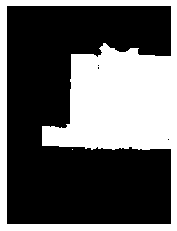

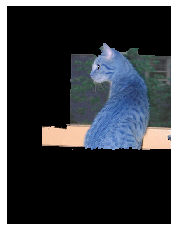

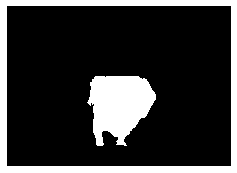

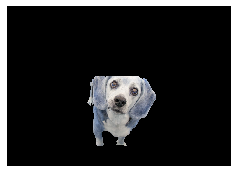

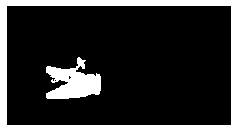

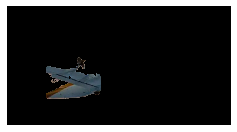

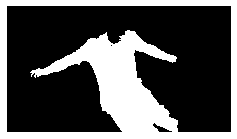

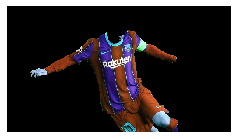

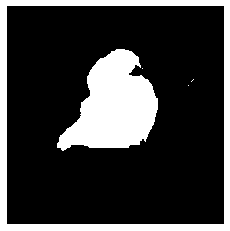

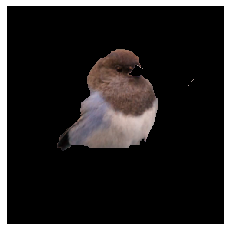

----------------------------------------------------------------------
For iteration  20  :


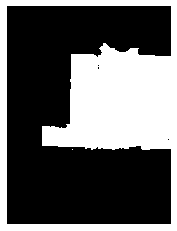

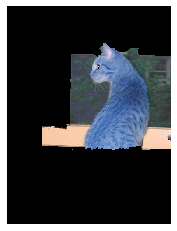

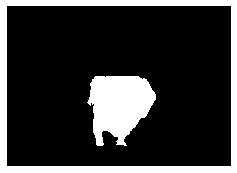

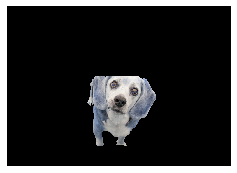

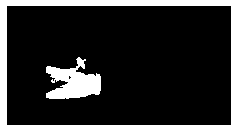

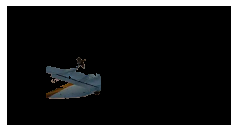

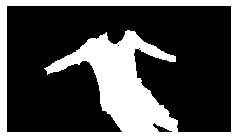

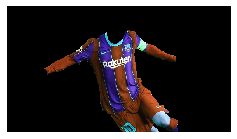

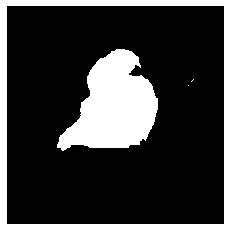

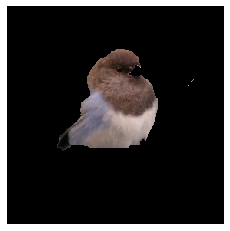

----------------------------------------------------------------------
For iteration  30  :


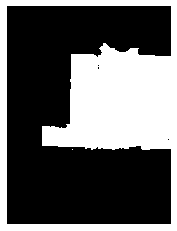

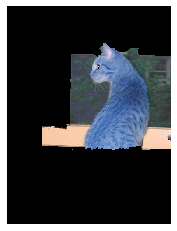

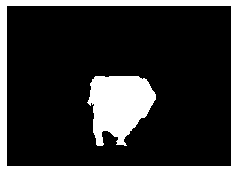

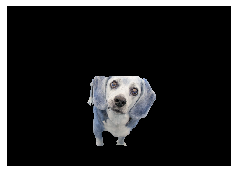

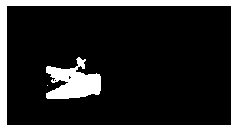

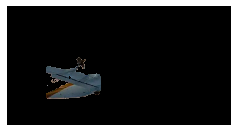

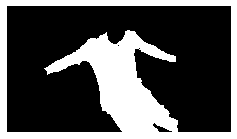

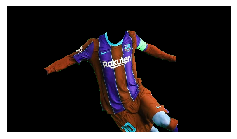

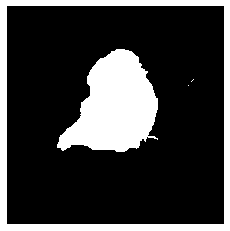

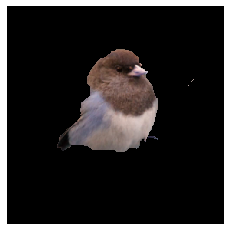

In [ ]:
# 4. Run grabcut algorithm.
bboxes = {'cat':(80,80,320,250), 'dog':(50,300,600,300), 'plane': (180,80,250,800), 'messi':(10,80,600,500), 'bird':(100,100,350,250)}
bbox = bboxes[img_name]

for i in [10,20,30]:
  print("----------------------------------------------------------------------")
  print("For iteration ",i," :")
  for key,val in bboxes.items():
    bbox = bboxes[key]
    address='/content/Part2_GraphCut/'+key+'.jpg'
    img = cv2.imread(address)

    (grabcut_mask, bgModel, fgModel) = run_grabcut(img, bbox,i)
    show_image(grabcut_mask)
    masked_img = img*grabcut_mask[:,:,np.newaxis]
    show_image(masked_img)


**Observation**: <br>
1] For the 10 iteration the results seem to similar. <br> 2] But the 20 iteration the performance is improved which can be observed in the bird image where the beak is included with 20 iterations. <br>
3] Greater number of iterations, the better the edge outline after grabcut implementation.<br>
4] As the outliers gets eliminated and we get a clean outline of the object in foreground.

### Hints 
- You may refer to https://docs.opencv.org/4.x/dd/dfc/tutorial_js_grabcut.html to implement run_grabcut()